In [53]:
import pandas as pd
import spacy
import en_core_web_md
from time import time
import re
import numpy as np
import random
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_predict, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import operator

In [54]:
# !python -m spacy download en_core_web_md

# Présentation et objectifs

Le but de ce projet est d'appliquer des méthodes de Natural Language Processing à un problème de classification de textes. Pour cela, nous allons prendre exemple sur un dataset de synopsis films labellisés par leur genre. Le but sera alors de prédire le genre d'un film connaissant son synopsis.

Les membres du projet sont ADIM Mehdi, BABINET Pierre, DARTIGUENAVE Aliénor et KUOCH Thomas.

# Description des données

[Text(0, 0.5, 'proportion'),
 Text(0.5, 0, 'categorie'),
 Text(0.5, 1.0, 'Proportion des catégories de films dans le dataset')]

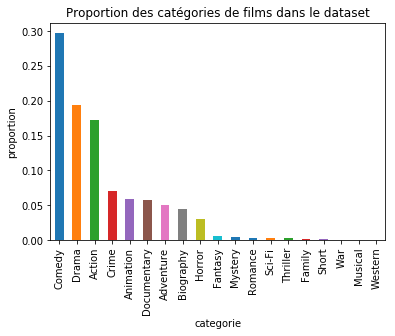

In [55]:
df = pd.read_csv('data.csv')
ax = df['Genre1'].value_counts(normalize=True).plot(kind='bar')
ax.set(xlabel="categorie", ylabel="proportion", title="Proportion des catégories de films dans le dataset")

In [56]:
print("Il y a {} films dans le dataset".format(len(df)))

Il y a 4000 films dans le dataset


On ne sélectionne seulement les catégories qui ont plus de 100 films.

[Text(0, 0.5, 'proportion'),
 Text(0.5, 0, 'categorie'),
 Text(0.5, 1.0, 'Proportion des catégories de films dans le dataset après sélection')]

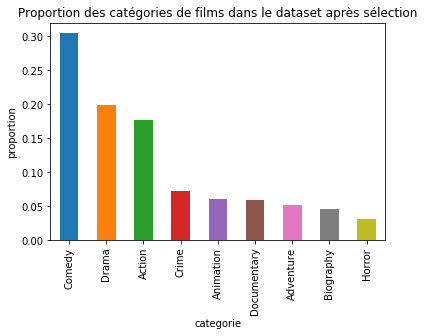

In [57]:
# Select only genres which have more than 100 synopsis
genres = pd.DataFrame(df['Genre1'].value_counts())
to_select = genres.loc[genres['Genre1'] > 100]
to_select = list(to_select.index.values)
df = df[(df.Genre1.isin(to_select))]
df = df.reset_index()

ax = df['Genre1'].value_counts(normalize=True).plot(kind='bar')
ax.set(xlabel="categorie", ylabel="proportion", title="Proportion des catégories de films dans le dataset après sélection")

# Lemmatisation

On procède à la lemmatisation des synopsis

In [58]:
nlp = spacy.load('en', disable=['ner', 'parser'])

In [59]:
def cleaning(doc):
    txt = [token.lemma_ for token in doc if not token.is_stop]
    if len(txt) > 2:
        return ' '.join(txt)

In [60]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['Synopsis'])

In [61]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.71 mins


In [62]:
df_clean = pd.DataFrame({'clean': txt})

In [63]:
# Rearrange columns
df['Synopsis_clean'] = df_clean
cols = ['Title', 'Synopsis', 'Synopsis_clean', 'Genre1', 'Genre2', 'Genre3']
df = df[cols]

In [64]:
# Average of count words in Synopsis_clean

mean = []
std = []

for column in ['Synopsis', 'Synopsis_clean']:
    count_of_words = []
    for index, row in df.iterrows():
        phrase = row[column]
        try:
            count_of_words.append(len(phrase.split(" ")))
        except:
            pass
    mean.append(np.mean(count_of_words))
    std.append(np.std(count_of_words))

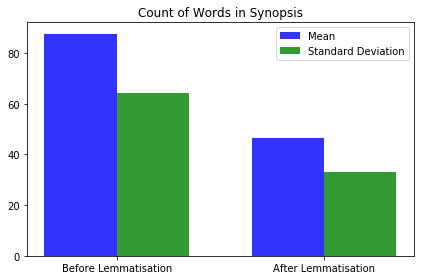

In [65]:
# data to plot
n_groups = 2

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, mean, bar_width,
alpha=opacity,
color='b',
label='Mean')
 
rects2 = plt.bar(index + bar_width, std, bar_width,
alpha=opacity,
color='g',
label='Standard Deviation')
 
plt.title('Count of Words in Synopsis')
plt.xticks(index + bar_width/2, ('Before Lemmatisation', 'After Lemmatisation'))
plt.legend()
 
plt.tight_layout()
plt.show()

# Construction du modèle de prédiction

## Stratification

Le dataset étant déséquilibré, il faut créer des jeux d'entraînement et de test qui tiennent compte de ces proportions. On crée ce que l'on appelle des jeux stratifiés.

In [66]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
for train_index, test_index in split.split(df, df["Genre1"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [67]:
weights = dict(strat_train_set['Genre1'].value_counts(normalize=True))

In [68]:
def get_XY(df):
    columns = [str(i) for i in range (0, 128)]
    X = np.empty((0,128))
    k = 0

    for index, row in df.iterrows():
        phrase = row['Synopsis_clean']
        embedded = nlp(phrase).vector
        X = np.vstack((X, embedded))
        
    Y = df['Genre1'].values
    return X, Y

In [69]:
Xtrain, Ytrain = get_XY(strat_train_set)
Xtest, Ytest = get_XY(strat_test_set)

## Normalization

In [70]:
sc = StandardScaler()
sc.fit(Xtrain)
Xtrain_norm = sc.transform(Xtrain)
Xtest_norm = sc.transform(Xtest)

## PCA

In [71]:
# pca = PCA(0.75) #On veut k tel qu'il permet de garder 75% de la variance
# pca.fit(Xtrain)
# Xtrain = pca.transform(Xtrain)
# Xtest = pca.transform(Xtest)

La PCA ne donne pas de meilleurs résultats.

## ML Classifiers

In [72]:
clfs = {
    'CART': DecisionTreeClassifier(class_weight=weights),
    'RF': RandomForestClassifier(n_estimators=300, max_depth=1, class_weight=weights),
    'SGD' : SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None),
    'svc' : LinearSVC()
}

In [73]:
genres = pd.DataFrame(df['Genre1'].value_counts())
genres = list(genres.index.values)

In [74]:
def run_classifier(clfs, Xtrain, Ytrain):
    for i in clfs:
        
        clf = clfs[i]
        clf.fit(Xtrain, Ytrain)

        Ypred = cross_val_predict(clf, Xtrain, Ytrain, cv=10)

        print('Classification report for classifier', i)
        print('Global Accuracy %s' % accuracy_score(Ypred, Ytrain))
        print(classification_report(Ytrain, Ypred, target_names=genres))

In [75]:
run_classifier(clfs, Xtrain_norm, Ytrain)

Classification report for classifier CART
Global Accuracy 0.20025632809996796
              precision    recall  f1-score   support

      Comedy       0.20      0.21      0.20       550
       Drama       0.04      0.04      0.04       162
      Action       0.10      0.09      0.09       190
       Crime       0.05      0.06      0.05       143
   Animation       0.33      0.32      0.32       951
 Documentary       0.09      0.10      0.09       226
   Adventure       0.12      0.12      0.12       183
   Biography       0.22      0.21      0.22       619
      Horror       0.02      0.02      0.02        97

   micro avg       0.20      0.20      0.20      3121
   macro avg       0.13      0.13      0.13      3121
weighted avg       0.20      0.20      0.20      3121

Classification report for classifier RF
Global Accuracy 0.30471002883691123
              precision    recall  f1-score   support

      Comedy       0.00      0.00      0.00       550
       Drama       0.00      0.0

Cette première approche ne donne pas de résultats satisfaisants.

# Méthode TFIDF

Il s'agit maintenant d'essayer la méthode TFIDF pour préparer nos données avant d'essayer nos modèles.

In [76]:
Xtrain, Ytrain = strat_train_set['Synopsis_clean'], strat_train_set['Genre1']
Xtest, Ytest = strat_test_set['Synopsis_clean'], strat_test_set['Genre1']

In [77]:
def run_pipeline(clfs, Xtrain, Ytrain):
    for i in clfs:
        clf = clfs[i]
        
        pipeline = Pipeline([('vect', CountVectorizer()),
                       ('tfidf', TfidfTransformer()),
                       ('clf', clf),
                      ])
        
        pipeline.fit(Xtrain, Ytrain)
        
        Ypred = cross_val_predict(pipeline, Xtrain, Ytrain, cv=5)
        print('Classification report for classifier', i)
        print('Global Accuracy %s' % accuracy_score(Ypred, Ytrain))
        print(classification_report(Ytrain, Ypred, target_names=genres))

In [78]:
run_pipeline(clfs, Xtrain, Ytrain)

Classification report for classifier CART
Global Accuracy 0.30278756808715157
              precision    recall  f1-score   support

      Comedy       0.35      0.40      0.38       550
       Drama       0.06      0.05      0.06       162
      Action       0.15      0.11      0.12       190
       Crime       0.09      0.06      0.07       143
   Animation       0.41      0.48      0.44       951
 Documentary       0.13      0.09      0.11       226
   Adventure       0.41      0.33      0.37       183
   Biography       0.24      0.24      0.24       619
      Horror       0.06      0.05      0.05        97

   micro avg       0.30      0.30      0.30      3121
   macro avg       0.21      0.20      0.20      3121
weighted avg       0.29      0.30      0.29      3121

Classification report for classifier RF
Global Accuracy 0.30471002883691123
              precision    recall  f1-score   support

      Comedy       0.00      0.00      0.00       550
       Drama       0.00      0.0

Le meilleur classifier est le SGDGradient et le LinearSVC

## Classifieur SGD

In [79]:
cv = CountVectorizer()
Xtrain_cv = cv.fit_transform(Xtrain)

In [80]:
sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=None, max_iter=5, tol=None, class_weight = None)

tfidf = TfidfVectorizer()
tfidf.fit(Xtrain, Ytrain)
Xtrain_tfidf = tfidf.transform(Xtrain)

Ypred = cross_val_predict(sgd, Xtrain_tfidf, Ytrain, cv=10)      

print('Classification report for classifier SGD')
print('Global Accuracy %s' % accuracy_score(Ypred, Ytrain))
print(classification_report(Ytrain, Ypred, target_names=genres))

Classification report for classifier SGD
Global Accuracy 0.49086831143864146
              precision    recall  f1-score   support

      Comedy       0.51      0.72      0.60       550
       Drama       0.43      0.07      0.13       162
      Action       0.66      0.23      0.34       190
       Crime       0.42      0.08      0.13       143
   Animation       0.49      0.80      0.61       951
 Documentary       0.36      0.11      0.17       226
   Adventure       0.66      0.56      0.61       183
   Biography       0.40      0.27      0.32       619
      Horror       0.53      0.10      0.17        97

   micro avg       0.49      0.49      0.49      3121
   macro avg       0.49      0.33      0.34      3121
weighted avg       0.48      0.49      0.44      3121



In [81]:
#Evaluation du Classifier
sgd.fit(Xtrain_tfidf, Ytrain)

Xtest_tfidf = tfidf.transform(Xtest)
Ypred = sgd.predict(Xtest_tfidf)
print('Classification report for classifier SGD')
print('Global Accuracy %s' % accuracy_score(Ypred, Ytest))
print(classification_report(Ytest, Ypred, target_names=genres))

Classification report for classifier SGD
Global Accuracy 0.5236875800256082
              precision    recall  f1-score   support

      Comedy       0.56      0.74      0.64       138
       Drama       0.67      0.10      0.17        41
      Action       0.67      0.30      0.41        47
       Crime       0.43      0.08      0.14        36
   Animation       0.50      0.82      0.62       238
 Documentary       0.42      0.14      0.21        56
   Adventure       0.64      0.61      0.62        46
   Biography       0.45      0.30      0.36       155
      Horror       0.90      0.38      0.53        24

   micro avg       0.52      0.52      0.52       781
   macro avg       0.58      0.38      0.41       781
weighted avg       0.53      0.52      0.48       781



## Classifieur SVM 

In [82]:
svc = LinearSVC()

tfidf = TfidfVectorizer()
tfidf.fit(Xtrain, Ytrain)
Xtrain_tfidf = tfidf.transform(Xtrain)

Ypred = cross_val_predict(svc, Xtrain_tfidf, Ytrain, cv=10)      

print('Classification report for LinearSVM')
print('Global Accuracy %s' % accuracy_score(Ypred, Ytrain))
print(classification_report(Ytrain, Ypred, target_names=genres))

Classification report for LinearSVM
Global Accuracy 0.47965395706504327
              precision    recall  f1-score   support

      Comedy       0.52      0.65      0.58       550
       Drama       0.33      0.10      0.15       162
      Action       0.56      0.21      0.31       190
       Crime       0.39      0.08      0.13       143
   Animation       0.50      0.71      0.59       951
 Documentary       0.41      0.18      0.25       226
   Adventure       0.73      0.50      0.60       183
   Biography       0.36      0.40      0.38       619
      Horror       0.60      0.12      0.21        97

   micro avg       0.48      0.48      0.48      3121
   macro avg       0.49      0.33      0.35      3121
weighted avg       0.48      0.48      0.45      3121



In [83]:
#Evaluation du Classifier
svc.fit(Xtrain_tfidf, Ytrain)

Xtest_tfidf = tfidf.transform(Xtest)
Ypred = svc.predict(Xtest_tfidf)
print('Classification report for classifier LinearSVC')
print('Global Accuracy %s' % accuracy_score(Ypred, Ytest))
print(classification_report(Ytest, Ypred, target_names=genres))

Classification report for classifier LinearSVC
Global Accuracy 0.5198463508322664
              precision    recall  f1-score   support

      Comedy       0.58      0.70      0.63       138
       Drama       0.50      0.15      0.23        41
      Action       0.58      0.32      0.41        47
       Crime       0.50      0.17      0.25        36
   Animation       0.52      0.71      0.60       238
 Documentary       0.34      0.18      0.24        56
   Adventure       0.75      0.59      0.66        46
   Biography       0.42      0.45      0.43       155
      Horror       0.88      0.29      0.44        24

   micro avg       0.52      0.52      0.52       781
   macro avg       0.56      0.39      0.43       781
weighted avg       0.52      0.52      0.50       781



## Matrice de confusion

In [84]:
cm = confusion_matrix(Ypred, Ytest, labels=genres)
cm = cm / cm.astype(np.float).sum(axis=0)
cm = cm.round(2)

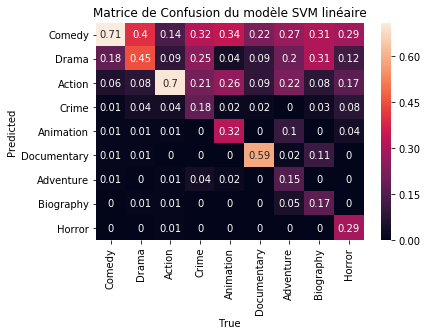

In [85]:
ax = sns.heatmap(cm, annot=True)

ax.set_xticklabels(genres)
ax.set_yticklabels(genres)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title("Matrice de Confusion du modèle SVM linéaire")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
ax

# Conclusion

Malgré nos efforts et nos essais de différents modèles et approches, le problème reste difficile et nous n'avions pas réussi à avoir mieux qu'une précision de 50%. La meilleure méthode a été de lemmatiser les synopsis, de construire la matrice TFIDF et d'entraîner notre modèle sur cette matrice. 